# Logistic Regression on full feature set

In [8]:
# Let's import packages

import pandas as pd
import numpy as np
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV, PredefinedSplit
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report, confusion_matrix
import os
import joblib

data_path = f"../../../data/image_data/"

# Let's specify file paths based on current directory
image1_path = os.path.join(data_path, "image1.txt")
image2_path = os.path.join(data_path, "image2.txt")
image3_path = os.path.join(data_path, "image3.txt")

# Let's load the data
image_1 = pd.read_csv(image1_path, delim_whitespace=True, header=None)
image_2 = pd.read_csv(image2_path, delim_whitespace=True, header=None)
image_3 = pd.read_csv(image3_path, delim_whitespace=True, header=None)

# We define column names
column_names = ['y_coor', 'x_coor', 'expert_label', 'NDAI', 'SD', 'CORR',
                'Radiance_angle_DF', 'Radiance_angle_CF', 'Radiance_angle_BF',
                'Radiance_angle_AF', 'Radiance_angle_AN']

# Let's assign column names to the datasets
image_1.columns = column_names
image_2.columns = column_names
image_3.columns = column_names

# Let's filter out uncertain data (expert_label = 0)
train_on1 = image_1[image_1['expert_label'] != 0]
validate_on2 = image_2[image_2['expert_label'] != 0]

# Let's select features (drop expert_label and coordinates)
x_train1 = train_on1.drop(columns=['expert_label', 'x_coor', 'y_coor'])
y_train1 = train_on1['expert_label']

x_validate2 = validate_on2.drop(columns=['expert_label', 'x_coor', 'y_coor'])
y_validate2 = validate_on2['expert_label']

# We combine training and validation data for cross-validation
X = pd.concat([x_train1, x_validate2], ignore_index=True)
y = pd.concat([y_train1, y_validate2], ignore_index=True)

# We create test fold array for cross-validation
test_fold = np.ones(len(X))
test_fold[:len(x_train1)] = 0  # Image 1 as training (0)
test_fold[len(x_train1):] = 1  # Image 2 as validation (1)

# We create PredefinedSplit object
ps = PredefinedSplit(test_fold)

# Standardize features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# We define logistic regression model and hyperparameters for tuning
log_reg = LogisticRegression(max_iter=500, random_state=42)
param_grid = {
    'C': [0.01, 0.1, 1, 10, 100],        # Regularization strength
    'penalty': ['l1', 'l2', 'elasticnet'],  # Regularization type
    'solver': ['saga'],                    # Solver supporting elasticnet
    'l1_ratio': [0, 0.5, 1]               # Only used for elasticnet penalty
}

# We define multiple scoring metrics
scoring = {
    'roc_auc': 'roc_auc',
    'accuracy': 'accuracy'
}

# We use GridSearchCV for logistic regression
grid_search = GridSearchCV(
    estimator=log_reg,
    param_grid=param_grid,
    scoring=scoring,
    cv=ps,
    refit='roc_auc',
    n_jobs=-1
)

# We fit the model with cross-validation
grid_search.fit(X_scaled, y)

# We access and print the best parameters and scores
best_params = grid_search.best_params_
best_roc_auc = grid_search.cv_results_['mean_test_roc_auc'].max()
best_accuracy = grid_search.cv_results_['mean_test_accuracy'].max()

print("Best ROC AUC:", best_roc_auc)
print("Best Accuracy:", best_accuracy)
print("Best Parameters:", best_params)

# We save the model trained on the whole training data with best hyperparameters
best_log_reg_full = grid_search.best_estimator_
joblib.dump(best_log_reg_full, 'best_logistic_regression_model_full.pkl')

# We evaluate on test set (image 3)
test_on3 = image_3[image_3['expert_label'] != 0]
X_test = test_on3.drop(columns=['expert_label', 'x_coor', 'y_coor'])
y_test = test_on3['expert_label']
X_test_scaled = scaler.transform(X_test)

# We predict and evaluate on test data
y_test_pred = best_log_reg_full.predict(X_test_scaled)

print("Test set classification report:")
print(classification_report(y_test, y_test_pred))

print("Test set confusion matrix:")
print(confusion_matrix(y_test, y_test_pred))

/var/folders/dn/rkkxq6wj6tzgm8gxb2zx45hr0000gn/T/ipykernel_37317/1542063267.py:20: FutureWarning: The 'delim_whitespace' keyword in pd.read_csv is deprecated and will be removed in a future version. Use ``sep='\s+'`` instead
  image_1 = pd.read_csv(image1_path, delim_whitespace=True, header=None)
/var/folders/dn/rkkxq6wj6tzgm8gxb2zx45hr0000gn/T/ipykernel_37317/1542063267.py:21: FutureWarning: The 'delim_whitespace' keyword in pd.read_csv is deprecated and will be removed in a future version. Use ``sep='\s+'`` instead
  image_2 = pd.read_csv(image2_path, delim_whitespace=True, header=None)
/var/folders/dn/rkkxq6wj6tzgm8gxb2zx45hr0000gn/T/ipykernel_37317/1542063267.py:22: FutureWarning: The 'delim_whitespace' keyword in pd.read_csv is deprecated and will be removed in a future version. Use ``sep='\s+'`` instead
  image_3 = pd.read_csv(image3_path, delim_whitespace=True, header=None)
/Users/bogdan/miniconda3/envs/215a/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1175: Us

Best ROC AUC: 0.8267433718719036
Best Accuracy: 0.7123258162210024
Best Parameters: {'C': 0.01, 'l1_ratio': 0, 'penalty': 'l2', 'solver': 'saga'}
Test set classification report:
              precision    recall  f1-score   support

        -1.0       0.78      0.88      0.82     33752
         1.0       0.75      0.61      0.67     21244

    accuracy                           0.77     54996
   macro avg       0.77      0.74      0.75     54996
weighted avg       0.77      0.77      0.77     54996

Test set confusion matrix:
[[29545  4207]
 [ 8348 12896]]


# Logistic Regression - reduced feature set

In [2]:
# Let's select features (drop expert_label and coordinates)
columns_to_drop = ['expert_label', 'x_coor', 'y_coor', 'Radiance_angle_DF', 
                   'Radiance_angle_CF', 'Radiance_angle_BF', 'Radiance_angle_AF', 'Radiance_angle_AN']
x_train1 = train_on1.drop(columns=columns_to_drop)
y_train1 = train_on1['expert_label']

x_validate2 = validate_on2.drop(columns=columns_to_drop)
y_validate2 = validate_on2['expert_label']

# We combine training and validation data for cross-validation
X = pd.concat([x_train1, x_validate2], ignore_index=True)
y = pd.concat([y_train1, y_validate2], ignore_index=True)

# We create test fold array for cross-validation
test_fold = np.ones(len(X))
test_fold[:len(x_train1)] = 0  # Image 1 as training (0)
test_fold[len(x_train1):] = 1  # Image 2 as validation (1)

# We create PredefinedSplit object
ps = PredefinedSplit(test_fold)

# Standardize features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# We define logistic regression model and hyperparameters for tuning
log_reg = LogisticRegression(max_iter=500, random_state=42)
param_grid = {
    'C': [0.01, 0.1, 1, 10, 100],        # Regularization strength
    'penalty': ['l1', 'l2', 'elasticnet'],  # Regularization type
    'solver': ['saga'],                    # Solver supporting elasticnet
    'l1_ratio': [0, 0.5, 1]               # Only used for elasticnet penalty
}

# We define multiple scoring metrics
scoring = {
    'roc_auc': 'roc_auc',
    'accuracy': 'accuracy'
}

# We use GridSearchCV for logistic regression
grid_search = GridSearchCV(
    estimator=log_reg,
    param_grid=param_grid,
    scoring=scoring,
    cv=ps,
    refit='roc_auc',
    n_jobs=-1
)

# We fit the model with cross-validation
grid_search.fit(X_scaled, y)

# We access and print the best parameters and scores
best_params = grid_search.best_params_
best_roc_auc = grid_search.cv_results_['mean_test_roc_auc'].max()
best_accuracy = grid_search.cv_results_['mean_test_accuracy'].max()

print("Best ROC AUC:", best_roc_auc)
print("Best Accuracy:", best_accuracy)
print("Best Parameters:", best_params)

# We save the model trained on the whole training data with best hyperparameters
best_log_reg_reduced = grid_search.best_estimator_
joblib.dump(best_log_reg_reduced, 'best_logistic_regression_model_reduced.pkl')

# We evaluate on test set (image 3)
test_on3 = image_3[image_3['expert_label'] != 0]
X_test_reduced = test_on3.drop(columns=columns_to_drop)
y_test = test_on3['expert_label']
X_test_reduced_scaled = scaler.transform(X_test_reduced)

# We predict and evaluate on test data
y_test_pred = best_log_reg_reduced.predict(X_test_reduced_scaled)

print("Test set classification report:")
print(classification_report(y_test, y_test_pred))

print("Test set confusion matrix:")
print(confusion_matrix(y_test, y_test_pred))

/Users/bogdan/miniconda3/envs/215a/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  warnings.warn(
/Users/bogdan/miniconda3/envs/215a/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  warnings.warn(
/Users/bogdan/miniconda3/envs/215a/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn(
/Users/bogdan/miniconda3/envs/215a/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn(
/Users/bogdan/miniconda3/envs/215a/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1175: UserWarning: l1_ratio parameter is only used

Best ROC AUC: 0.8964787836938062
Best Accuracy: 0.8223280033852047
Best Parameters: {'C': 0.01, 'l1_ratio': 0, 'penalty': 'l2', 'solver': 'saga'}
Test set classification report:
              precision    recall  f1-score   support

        -1.0       0.81      0.86      0.84     33752
         1.0       0.76      0.69      0.72     21244

    accuracy                           0.80     54996
   macro avg       0.79      0.78      0.78     54996
weighted avg       0.79      0.80      0.79     54996

Test set confusion matrix:
[[29123  4629]
 [ 6644 14600]]


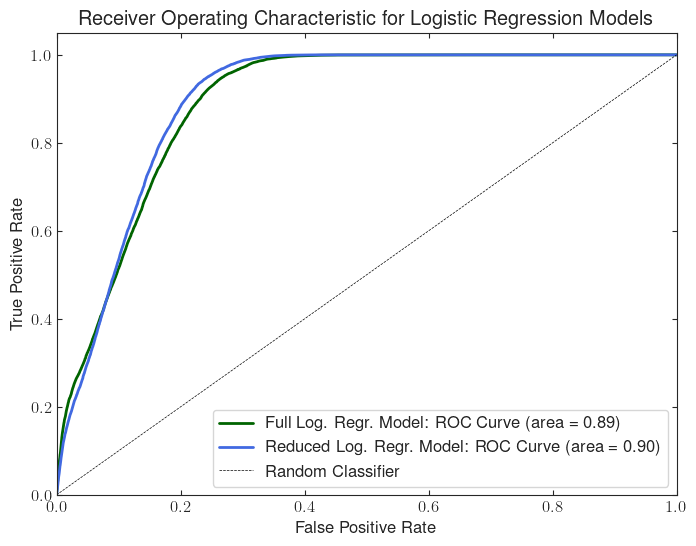

In [6]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import roc_curve, auc

# After fitting the model, let's make predictions on the test set and get predicted probabilities
y_pred_prob_full = best_log_reg_full.predict_proba(X_test_scaled)[:, 1] 
y_pred_prob_reduced = best_log_reg_reduced.predict_proba(X_test_reduced_scaled)[:, 1]

# Let's compute ROC curves
fpr_full, tpr_full, _ = roc_curve(y_test, y_pred_prob_full)
roc_auc_full = auc(fpr_full, tpr_full)
fpr_reduced, tpr_reduced , _ = roc_curve(y_test, y_pred_prob_reduced)
roc_auc_reduced = auc(fpr_reduced, tpr_reduced)


sns.set_style("white")
plt.rcParams["text.usetex"] = True
plt.rcParams["font.family"] =  "Helvetica"
plt.rcParams["font.size"] = 12
plt.rcParams["xtick.direction"] = "in" 
plt.rcParams["ytick.direction"] = "in" 
plt.rcParams["xtick.top"] = True
plt.rcParams["xtick.bottom"] = True 
plt.rcParams["ytick.right"] = True 
plt.rcParams["ytick.left"] = True

# Create the ROC curve plot
plt.figure(figsize=(8, 6))
sns.lineplot(
    x=fpr_full,
    y=tpr_full,
    label=f'Full Log. Regr. Model: ROC Curve (area = {roc_auc_full:.2f})',
    lw=2,
    color="darkgreen",
    errorbar=None
)
sns.lineplot(
    x=fpr_reduced,
    y=tpr_reduced,
    label=f'Reduced Log. Regr. Model: ROC Curve (area = {roc_auc_reduced:.2f})',
    lw=2,
    color="royalblue",
    errorbar=None)
sns.lineplot(x=[0, 1], y=[0, 1], color='black', lw=0.5, linestyle='--', errorbar=None, label="Random Classifier")

# Customize the plot
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic for Logistic Regression Models')
plt.legend(loc="lower right")
plt.savefig("../../../figs/roc_log_regr.pdf")
plt.show()

In [7]:
# Save tpr and fpr to compare with other models
roc_df = pd.DataFrame({"fpr": fpr_reduced, "tpr": tpr_reduced})
roc_df.to_csv("../../../data/roc_data/roc_log_reg.csv", index=False)